# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 3/3

# **Creación de modelos**

PAra la siguiente parte se crearan los siguientes modelos de clasificación simple:
- model1
- model2

## **MobileNetV3**

### **Small Version**

#### **Adam Optimizer**

Found 192 images belonging to 2 classes.


Found 47 images belonging to 2 classes.
Epoch 1/200


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.4663 - loss: 0.7026 - val_accuracy: 0.5532 - val_loss: 0.6928
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.5560 - loss: 0.6920 - val_accuracy: 0.5532 - val_loss: 0.6928
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.5295 - loss: 0.6955 - val_accuracy: 0.5532 - val_loss: 0.6932
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5751 - loss: 0.6895 - val_accuracy: 0.5532 - val_loss: 0.6928
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.5423 - loss: 0.6938 - val_accuracy: 0.5532 - val_loss: 0.6931
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.4554 - loss: 0.6971 - val_accuracy: 0.4468 - val_loss: 0.6931
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.4554 - loss: 0.6921 - val_accuracy: 0.5532 - val_loss: 0.6931
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.4600 - loss: 0.7003 - val_accuracy: 0.4468 - val_loss: 0.6

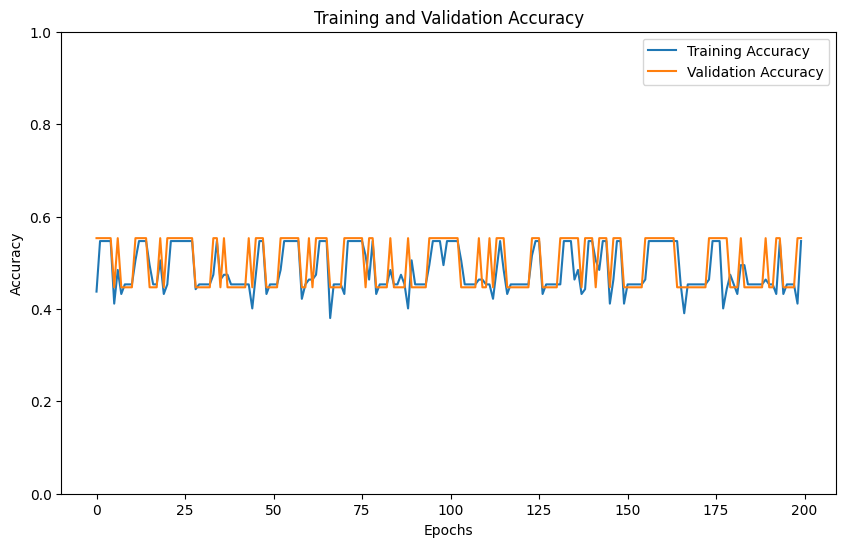

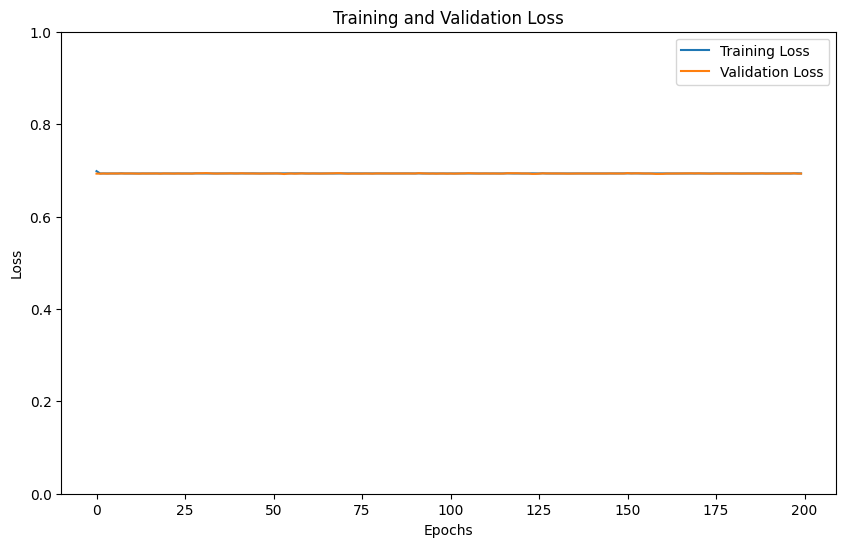

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        #batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        #batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.
    num_classes (int): Número de clases para la clasificación. Se espera 2 para binaria.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,          # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights, # Ajuste de pesos para cada clase
    #callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylim(0, 1.0)
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylim(0, 1.0)
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation

#### **SGD optimizer**

Found 138 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 680ms/step - accuracy: 0.5440 - loss: 0.7912 - val_accuracy: 0.5588 - val_loss: 0.6192
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5139 - loss: 0.9813 - val_accuracy: 0.4412 - val_loss: 0.6983
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.4264 - loss: 0.6964 - val_accuracy: 0.5588 - val_loss: 0.7633
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5301 - loss: 0.6969 - val_accuracy: 0.5588 - val_loss: 0.7331
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5273 - loss: 0.6935 - val_accuracy: 0.5588 - val_loss: 0.6937
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5437 - loss: 0.6920 - val_accuracy: 0.5588 - val_loss: 0.6360
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5463 - loss: 0.6884 - val_accuracy: 0.5588 - val_loss: 0.6225
Epoch 8/100
5/5 ━━━━━━━━━━━━━━

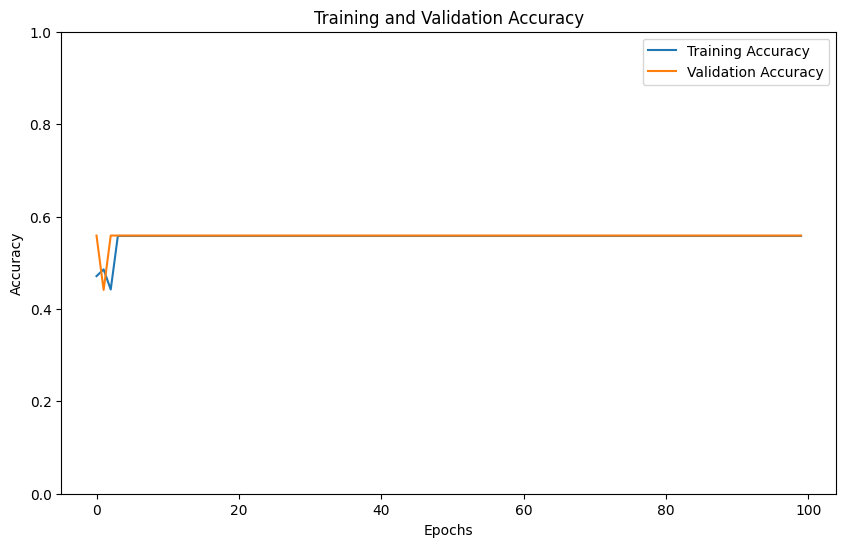

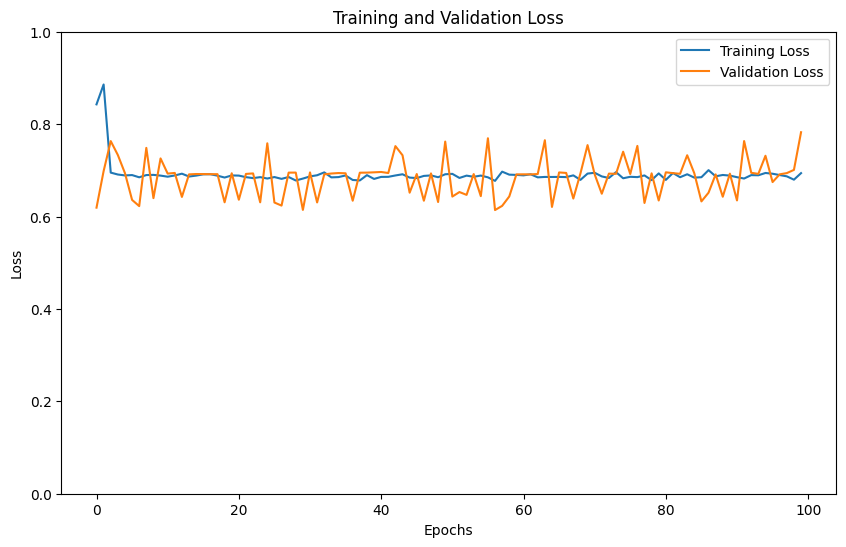

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Definir generadores de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
    validation_split=0.2  # Reservar 20% de los datos para validación
)

data_dir = 'db_unal/organized/images/raw'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=50,
    class_mode='binary',
    subset='training'  # Especificar que esto es para el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=20,
    class_mode='binary',
    subset='validation'  # Especificar que esto es para el conjunto de validación
)

# Cargar modelo preentrenado
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los steps per epoch y validation steps
#train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
#val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Entrenar el modelo
history = model.fit(
    train_generator,
    #steps_per_epoch=train_steps,
    validation_data=validation_generator,
    #validation_steps=val_steps,
    epochs=100
)

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation

### **Large Version**

#### **Adam Optimizer**

#### **SGD optimizer**

## **ResNet**

### **ResNet50**

#### **Adam Optimizer**

#### **SGD Optimizer**

Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4495 - loss: 16.3645 - val_accuracy: 0.4468 - val_loss: 0.7024
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5010 - loss: 0.8831 - val_accuracy: 0.5532 - val_loss: 0.8100
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5422 - loss: 0.8832 - val_accuracy: 0.4468 - val_loss: 4.9188
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3935 - loss: 3.1201 - val_accuracy: 0.5532 - val_loss: 0.7430
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4904 - loss: 0.7218 - val_accuracy: 0.4468 - val_loss: 0.7485
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4400 - loss: 0.7621 - val_accuracy: 0.5532 - val_loss: 0.7160
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4860 - loss: 0.7480 - val_accuracy: 0.5532 - val_loss: 0.6887
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s

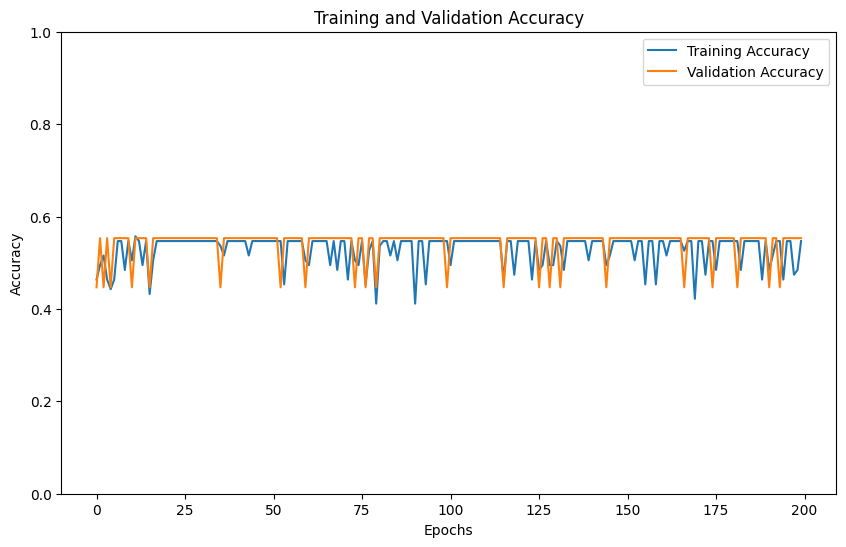

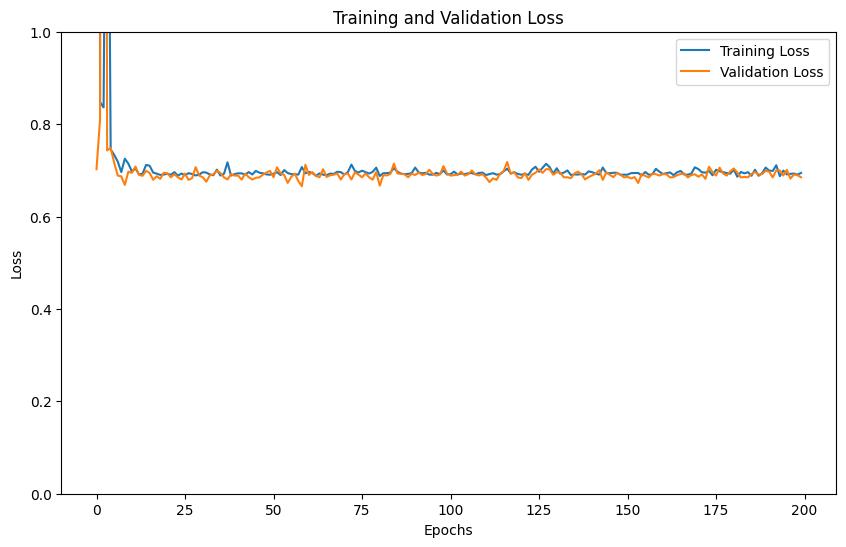

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Definir generadores de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reservar 20% de los datos para validación
)

data_dir = 'db_unal/organized/images/cropped'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=20,
    class_mode='binary',
    subset='training'  # Especificar que esto es para el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=6,
    class_mode='binary',
    subset='validation'  # Especificar que esto es para el conjunto de validación
)

# Cargar modelo preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=SGD(learning_rate=0.5, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los steps per epoch y validation steps
train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Entrenar el modelo
history = model.fit(
    train_generator,
    #steps_per_epoch=train_steps,
    validation_data=validation_generator,
    #validation_steps=val_steps,
    epochs=200
)

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation

### **ResNet101**

#### **Adam Optimizer**

#### **SGD Optimizer**

## **VGG**

### **VGG16**

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando VGG16 como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,         # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights,  # Ajuste de pesos para cada clase
    #callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation
plt.show()


Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/200


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4644 - loss: 0.7041 - val_accuracy: 0.4468 - val_loss: 0.6978
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4873 - loss: 0.6979 - val_accuracy: 0.4468 - val_loss: 0.7028
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4830 - loss: 0.6909 - val_accuracy: 0.4468 - val_loss: 0.7064
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5247 - loss: 0.6954 - val_accuracy: 0.4468 - val_loss: 0.7004
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4742 - loss: 0.7006 - val_accuracy: 0.4468 - val_loss: 0.6998
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4204 - loss: 0.6975 - val_accuracy: 0.4468 - val_loss: 0.6995
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5159 - loss: 0.6899 - val_accuracy: 0.4468 - val_loss: 0.6984
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4667 - loss: 0.6951 - val_accuracy: 0.4468 - val_loss: 0.6

KeyboardInterrupt: 

### **VGG19**

Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 975ms/step - accuracy: 0.5390 - loss: 0.7880 - val_accuracy: 0.5532 - val_loss: 0.6825
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 955ms/step - accuracy: 0.5039 - loss: 0.7320 - val_accuracy: 0.6809 - val_loss: 0.6837
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 968ms/step - accuracy: 0.4794 - loss: 0.7118 - val_accuracy: 0.5957 - val_loss: 0.6780
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 950ms/step - accuracy: 0.5277 - loss: 0.7159 - val_accuracy: 0.6596 - val_loss: 0.6828
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 961ms/step - accuracy: 0.5166 - loss: 0.6935 - val_accuracy: 0.4468 - val_loss: 0.7079
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 969ms/step - accuracy: 0.4618 - loss: 0.6987 - val_accuracy: 0.4468 - val_loss: 0.6954
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 960ms/step - accuracy: 0.4135 - loss: 0.6910 - val_accuracy: 0.4468 - val_loss: 0.6937
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 951ms/step - accuracy: 0.5212 - loss: 0.6995 - val_accuracy

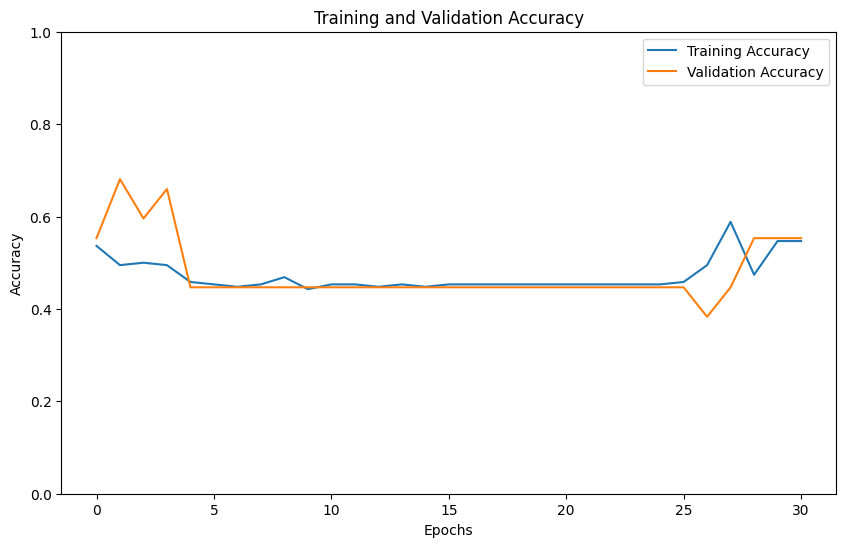

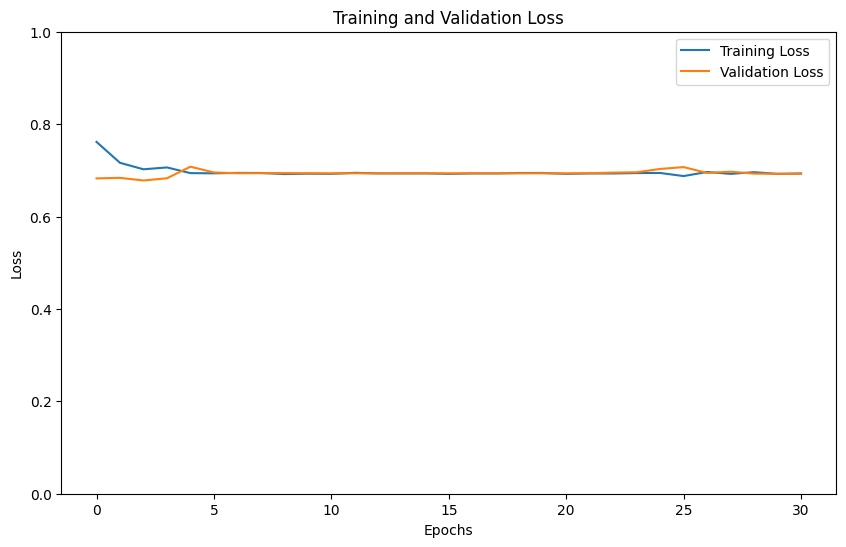

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando VGG19 como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,         # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights,  # Ajuste de pesos para cada clase
    #callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation
plt.show()

## **Xception**

Found 192 images belonging to 2 classes.


Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.5048 - loss: 0.6959 - val_accuracy: 0.4681 - val_loss: 0.6996
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.5728 - loss: 0.6876 - val_accuracy: 0.4894 - val_loss: 0.7026
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 373ms/step - accuracy: 0.4693 - loss: 0.7101 - val_accuracy: 0.4043 - val_loss: 0.7089
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step - accuracy: 0.4532 - loss: 0.7048 - val_accuracy: 0.4681 - val_loss: 0.7043
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 611ms/step - accuracy: 0.5697 - loss: 0.6754 - val_accuracy: 0.4681 - val_loss: 0.6980
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 413ms/step - accuracy: 0.4270 - loss: 0.7147 - val_accuracy: 0.4468 - val_loss: 0.7016
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.4617 - loss: 0.7198 - val_accuracy: 0.4468 - val_loss: 0.6959
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 404ms/step - accuracy: 0.5505 - loss: 0.6860 - val_accuracy

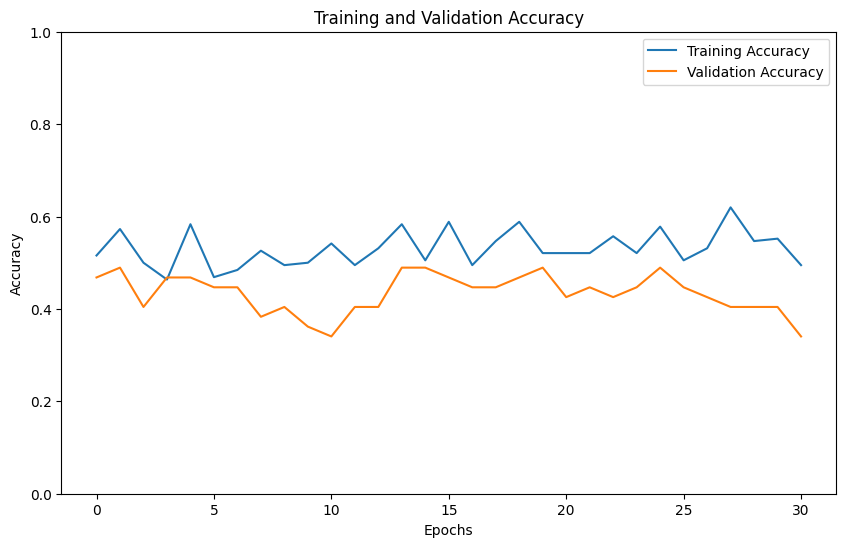

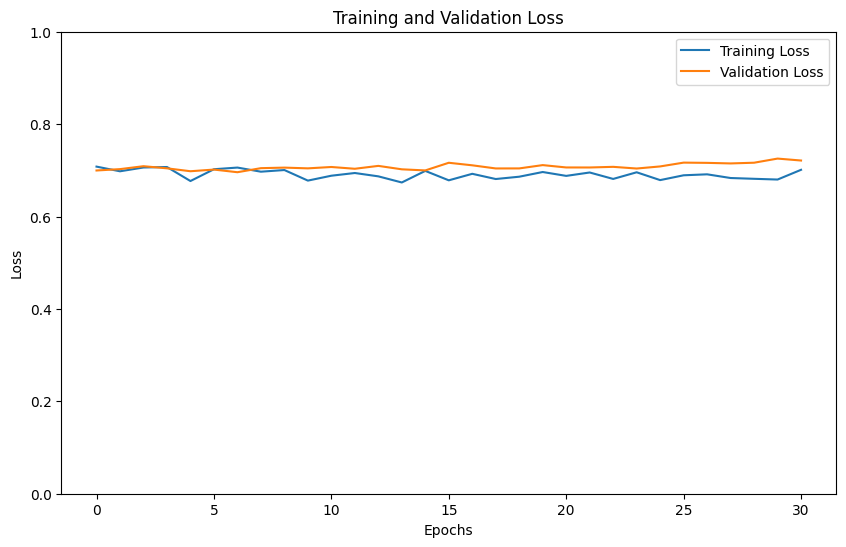

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando Xception como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,         # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights,  # Ajuste de pesos para cada clase
    #callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation
plt.show()


## **DenseNet**

Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 424ms/step - accuracy: 0.6277 - loss: 0.7942 - val_accuracy: 0.4255 - val_loss: 0.7240
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.5157 - loss: 0.6916 - val_accuracy: 0.5106 - val_loss: 0.7079
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.5220 - loss: 0.7070 - val_accuracy: 0.4894 - val_loss: 0.6936
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.5295 - loss: 0.6940 - val_accuracy: 0.4681 - val_loss: 0.6977
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.5652 - loss: 0.6919 - val_accuracy: 0.4681 - val_loss: 0.6999
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.4763 - loss: 0.6981 - val_accuracy: 0.5532 - val_loss: 0.6930
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.5498 - loss: 0.6928 - val_accuracy: 0.5532 - val_loss: 0.6929
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - accuracy: 0.5062 - loss: 0.6985 - val_accuracy

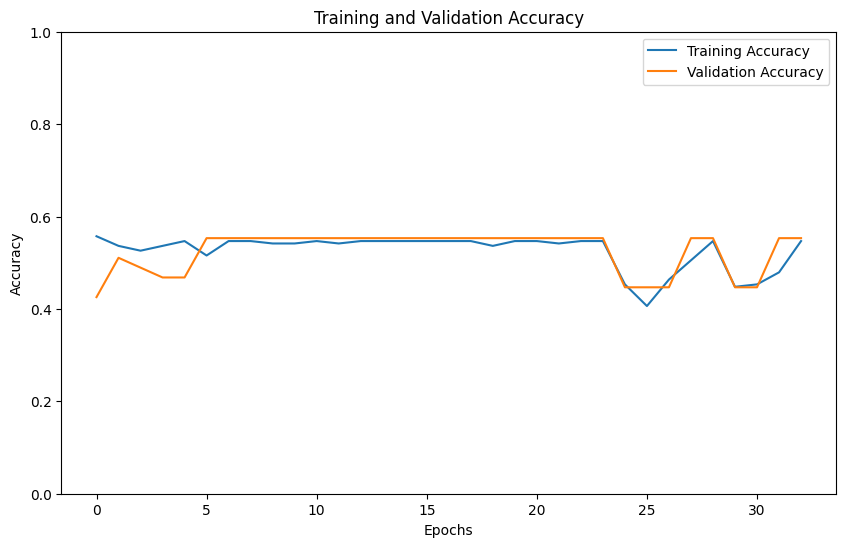

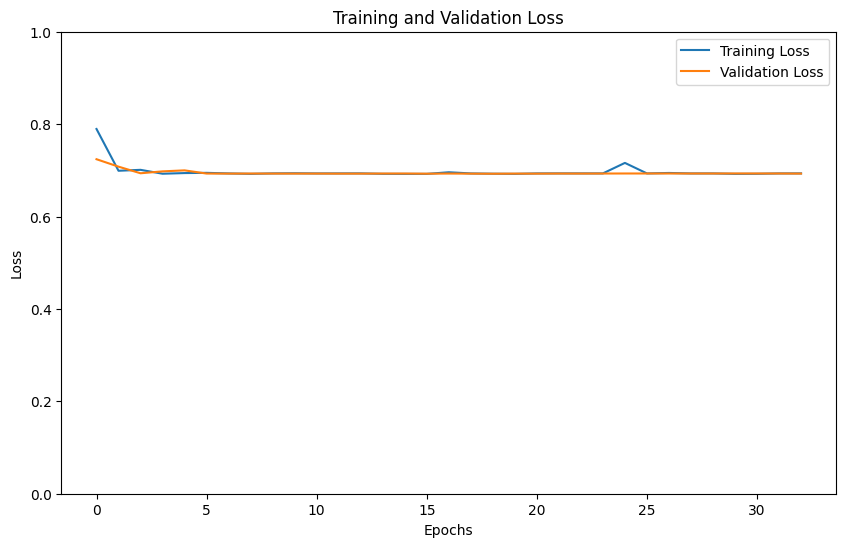

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando DenseNet como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduce la dimensionalidad de la salida del modelo base
        Dense(256, activation='relu'),  # Primera capa densa adicional con 256 neuronas
        Dropout(0.5),  # Dropout para reducir el sobreajuste
        Dense(128, activation='relu'),  # Segunda capa densa adicional con 128 neuronas
        Dropout(0.5),  # Dropout para reducir el sobreajuste
        Dense(64, activation='relu'),  # Tercera capa densa adicional con 64 neuronas
        Dropout(0.5),  # Dropout para reducir el sobreajuste
        Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,         # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights,  # Ajuste de pesos para cada clase
    callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation
plt.show()
